## Analyze A/B Test Results
## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

Let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
random.seed(42)

`1.` Read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows:

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Find the number of rows in the dataset.

In [3]:
print('The number of rows in the dataset is :',df.shape[0])

The number of rows in the dataset is : 294478


c. The number of unique users in the dataset.

In [4]:
print('The number of unique users in the dataset is: ',df.user_id.nunique())

The number of unique users in the dataset is:  290584


d. The proportion of users converted.

In [5]:
print(df.converted.value_counts(normalize=True))
print(' ')
print('The proportion of users converted is: %0.4f'%df.converted.value_counts(normalize=True)[1])

0    0.880341
1    0.119659
Name: converted, dtype: float64
 
The proportion of users converted is: 0.1197


e. The number of times the `landing_page` and `group` don't correctly match 

In [6]:
Not_match=((df.group=='treatment')==(df.landing_page=='old_page'))

print('The number of landing_page and group not correctly match:', df[Not_match].shape[0])

The number of landing_page and group not correctly match: 3893


f. Do any of the rows have missing values?

In [7]:
print(df.isnull().any())
print('None of the rows have missing values')

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool
None of the rows have missing values


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. We need to drop these rows, only use the trustworthy data.  

a. Store the new dataframe in **df2**, reset the index and check the information for `df2`.

In [7]:
df2=df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]
df2=df2.reset_index(drop=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290585 entries, 0 to 290584
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.1+ MB


In [8]:
# Double Check all of the incorrect rows were removed - this should be 0
print('The number of rows in df2: ', df2.shape[0])
print('The number of rows not correctly matched is: ',df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0])

The number of rows in df2:  290585
The number of rows not correctly matched is:  0


`3.` Explore more about the dataset `df2`

a. How many unique **user_id**s are in **df2**?

In [9]:
df2.user_id.nunique()
print('There are', df2.user_id.nunique(), 'unique user_ids in df2')

There are 290584 unique user_ids in df2


b. There is one **user_id** repeated in **df2**.  What is it?

In [10]:
df2[df2.user_id.duplicated()==True]

,user_id,timestamp,group,landing_page,converted
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [11]:
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted
1876,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**.

In [12]:
df2=df2.drop(df2.index[2862])
df2=df2.reset_index(drop=True)

In [13]:
#test if the duplicated row is dropped
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted
1876,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Find the conversion rate of the groups.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
converted=df2.converted.value_counts(normalize=True)
print(converted)
print('The probability of an individual converting regardless of the page they receive is:%0.4f '%converted[1])

0    0.880403
1    0.119597
Name: converted, dtype: float64
The probability of an individual converting regardless of the page they receive is:0.1196 



b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
convt_givn_group=df2.groupby('group')['converted'].value_counts(normalize=True)
print(convt_givn_group)
print(' ')
print('Given an individual in the control group, the probability they converted is %0.4f'%convt_givn_group[1])

group      converted
control    0            0.879614
           1            0.120386
treatment  0            0.881192
           1            0.118808
Name: converted, dtype: float64
 
Given an individual in the control group, the probability they converted is 0.1204


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
convt_givn_group2=df2.converted[(df2['group']=='treatment')].value_counts(normalize=True)
print(convt_givn_group2)
print('Given an idividual in the treatment group, the probability they converted is %0.4f'%convt_givn_group2[1])

0    0.881192
1    0.118808
Name: converted, dtype: float64
Given an idividual in the treatment group, the probability they converted is 0.1188


In [17]:
new_con_r=convt_givn_group2[1]
old_con_r=convt_givn_group[1]
obs_diffs=new_con_r-old_con_r
print('The observed conversion rate difference between new page and old page is: %0.4f'% obs_diffs)

The observed conversion rate difference between new page and old page is: -0.0016


d. What is the probability that an individual received the new page?

In [18]:
df.landing_page.value_counts(normalize=True)
print('The probability that an individual received the new page is 0.5')

The probability that an individual received the new page is 0.5


e. Explain if there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**From the calculation above, we can see that the conversion rate for old page in control group is 0.1204, the conversion rate for new page in treatment group is 0.1188, and the observed difference from new treatment page and old control page is -0.0016, the new treatment page has lower conversion rate than the old control page. So, we don't have sufficient evidence to conclude that the new treatment page leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test
There are some questions associated with A/B Test. 
Do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  

How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, we need to make the decision just based on all the data provided. We assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, and we can state the hypothesis in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages as below.

### $$H_0: p_{new} \leq p_{old}$$

### $$H_a: p_{new} > p_{old}$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. We are going to perform the Hypothesis test as follow: <br>

- Use a sample size for each page equal to their size in **ab_data.csv**.  <br>
- Simulate the sampling distribution for the conversion rate of new page and old page. 
- Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br>
- Use the sampling distributions to simulate the distribution under the null hypothesis, by creating a random normal distribution centered at 0 with the same spread and size.
- Compute the p-value by finding the proportion of values in the null distribution that were greater than our observed difference.
- Use the p-value to determine the statistical significance of our observed difference.

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
p_new=df2.converted.value_counts(normalize=True)[1]
print('The conversion rate for p_new under the null is {0:0.4f}'.format(p_new))

The conversion rate for p_new under the null is 0.1196


b. What is the **conversion rate** for $p_{old}$ under the null? <br>
 - Since under the null, the old page will greater or at least equal to the new page, so the old page will have the same conversion rate with new page at the limit point under the null

In [20]:
p_old=p_new
print('The conversion rate for p_new under the null is {0:0.4f}'.format(p_old))

The conversion rate for p_new under the null is 0.1196


c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
n_new=df2[df2.group=='treatment'].shape[0]
print('The number of individuals in the treatment group is :',n_new)

The number of individuals in the treatment group is : 145310


d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old=df2[df2.group=='control'].shape[0]
print('The number of individuals in the treatment group is :',n_old)

The number of individuals in the treatment group is : 145274


e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
size=n_new
new_samp = df2.sample(size, replace=True)
convt_givn_group_new=new_samp.groupby('group')['converted'].value_counts(normalize=True)
convt_givn_group_new

group      converted
control    0            0.879559
           1            0.120441
treatment  0            0.883214
           1            0.116786
Name: converted, dtype: float64

In [29]:
# take around 8 mins to run, start 6:50:7:08
new_page_converted=[]
size=n_new
for _ in range(10000):
    new_samp = df2.sample(size, replace=True)
    convt_givn_group_new=new_samp.groupby('group')['converted'].value_counts(normalize=True)
    new_con_rate = convt_givn_group_new[3]
    new_page_converted.append(new_con_rate)

(array([  12.,  107.,  579., 1640., 2751., 2633., 1593.,  547.,  129.,
           9.]),
 array([0.11508549, 0.11598979, 0.11689409, 0.11779839, 0.11870268,
        0.11960698, 0.12051128, 0.12141557, 0.12231987, 0.12322417,
        0.12412847]),
 <a list of 10 Patch objects>)

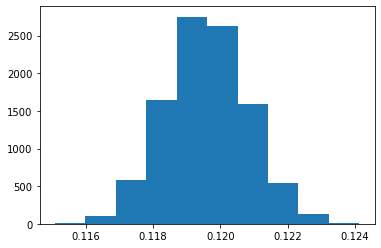

In [30]:
new_page_converted=np.array(new_page_converted)
null_new=np.random.normal(p_new, new_page_converted.std(), new_page_converted.size)
plt.hist(null_new)

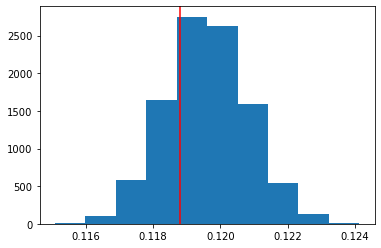

In [31]:
plt.hist(null_new)
plt.axvline(new_page_converted.mean(), c='red')

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [33]:
## take around 8 mins to run 7:11,7:22
old_page_converted=[]
size=n_old
for _ in range(10000):
    old_samp = df2.sample(size, replace=True)
    convt_givn_group_old=old_samp.groupby('group')['converted'].value_counts(normalize=True)
    old_con_rate=convt_givn_group_old[1]
    old_page_converted.append(old_con_rate)

(array([  24.,  127.,  574., 1465., 2484., 2687., 1712.,  682.,  205.,
          40.]),
 array([0.11527319, 0.11611923, 0.11696527, 0.11781131, 0.11865735,
        0.11950339, 0.12034943, 0.12119546, 0.1220415 , 0.12288754,
        0.12373358]),
 <a list of 10 Patch objects>)

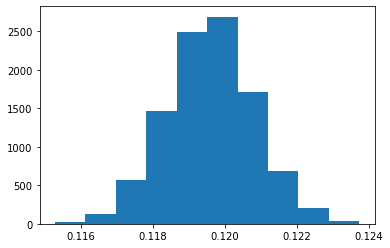

In [34]:
old_page_converted=np.array(old_page_converted)
null_old=np.random.normal(p_old, old_page_converted.std(), new_page_converted.size)
plt.hist(null_old)

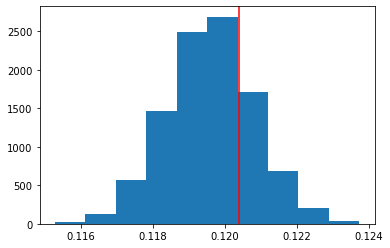

In [35]:
plt.hist(null_old)
plt.axvline(convt_givn_group[1], c='red')

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [31]:
p_diff=pd.DataFrame(new_page_converted).mean()-pd.DataFrame(old_page_converted).mean()

In [32]:
p_diff

0   -0.001577
dtype: float64

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [33]:
df2.groupby('group')['converted'].value_counts(normalize=True)

group      converted
control    0            0.879614
           1            0.120386
treatment  0            0.881192
           1            0.118808
Name: converted, dtype: float64

In [24]:
## take about 40 mins to run 9:00, 
p_diffs=[]
size=df2.shape[0]
for _ in range(10000):
    sample=df2.sample(size, replace=True)
    con_table=sample.groupby('group')['converted'].value_counts(normalize=True)
    new_con_rate=con_table[3]
    old_con_rate=con_table[1]
    p_diffs.append(new_con_rate-old_con_rate)

i. Plot a histogram of the **p_diffs**.

(array([   6.,   89.,  444., 1235., 2283., 2709., 1978.,  905.,  291.,
          60.]),
 array([-0.00598348, -0.00515808, -0.00433268, -0.00350729, -0.00268189,
        -0.00185649, -0.0010311 , -0.0002057 ,  0.0006197 ,  0.00144509,
         0.00227049]),
 <a list of 10 Patch objects>)

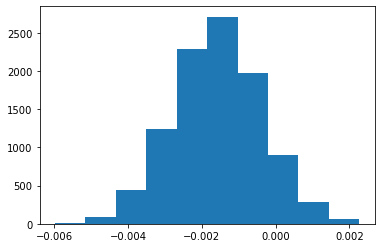

In [25]:
p_diffs=np.array(p_diffs)
plt.hist(p_diffs)

(array([   7.,   41.,  364., 1318., 2722., 2999., 1813.,  603.,  116.,
          17.]),
 array([0.11466542, 0.11561962, 0.11657381, 0.117528  , 0.11848219,
        0.11943638, 0.12039057, 0.12134476, 0.12229895, 0.12325315,
        0.12420734]),
 <a list of 10 Patch objects>)

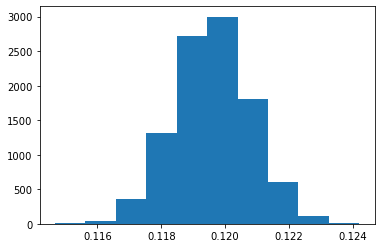

In [26]:
null_diffs=np.random.normal(p_new, p_diffs.std(), p_diffs.size)
plt.hist(null_diffs)

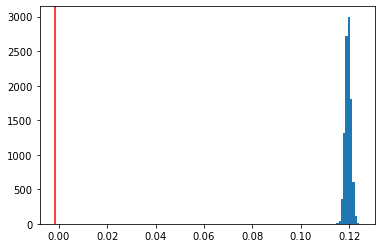

In [27]:
plt.hist(null_diffs)
plt.axvline(p_diffs.mean(), c='red')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
(null_diffs > obs_diffs).mean()

1.0

k. Explain the value in terms of whether or not there is a difference between the new and old pages?

**The p-value from the statistic is greater than 0.05, and we can conclude that the test result is not significant, and we can keep the null hypothesis. So, there is no difference of the conversion rate between new pages and old pages**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [36]:
df2.converted[df2.group=='control'].value_counts()

0    127785
1     17489
Name: converted, dtype: int64

In [37]:
import statsmodels.api as sm
convert_old = df2.converted[df2.group=='control'].value_counts()[1]
convert_new = df2.converted[df2.group=='treatment'].value_counts()[1]
n_old = df2[df2.landing_page=='old_page'].shape[0]
n_new = df2[df2.landing_page=='new_page'].shape[0]

m. Now use `stats.proportions_ztest` to compute the test statistic and p-value 

In [38]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
con_count = np.array([convert_old, convert_new])
nobs = np.array([n_old, n_new])
stat, pval = proportions_ztest(con_count, nobs)
print('the z-score is :', stat)
print('the p-value is :{0:0.3f}'.format(pval))

the z-score is : 1.3109241984234394
the p-value is :0.190


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  

**The z-score is 1.3109, and the associated p-value is 0.19 which is greater than 0.05, so we can conclude that the results of the test is not significant, and we can keep the null hypothesis. The conclusion agrees with the findings in the previous part.**

 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this part, we will see that the result achieved in the A/B test in Part II above can also be achieved by performing regression.<br>

a. Since each row is either a conversion or no conversion, what type of regression should be performing in this case?

**Each row is either converted or not converted. So the target variable is 'converted' which is a categorical variable, Logistic model can handle categorical outputs, so Logistic Regression should be used.**

b. The goal is to use **statsmodels** to fit the regression model we specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. First we need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [39]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['landing_page'])['new_page']

c. Use **statsmodels** to instantiate the logistic regression model on the two columns created in part b., then fit the model using the two columns created in part **b.** to predict whether or not an individual converts. 

In [40]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
log_mod = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. The summary of the model provided below.

In [41]:
log_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 04 Aug 2019   Pseudo R-squ.:               8.077e-06
Time:                        06:36:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [42]:
np.exp(log_mod.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

In [43]:
1/np.exp(log_mod.params)

intercept    7.306593
ab_page      1.015102
dtype: float64

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p-value associated with ab_page is 0.19, which is the same as found in the previous test.**

f. Now, we can consider other things that might influence whether or not an individual converts. Is it a good idea to consider other factors to add into the regression model.  Are there any disadvantages to adding additional terms into your regression model?

**It is always a good idea to consider other factors to be in the regression model to make the model more accurate. But there are also some disadvantages, eg:**<br>
**- the variables may have linear relationship between each other and produce inaccurate result**<br>
**- the added variable may cause the original variables in the model loose significance**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. Does it appear that country had an impact on conversion?

In [44]:
import pandas as pd 
df_country=pd.read_csv('countries.csv')
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [45]:
df_country[['country1','country2', 'country3']]=pd.get_dummies(df_country['country'])
df_country.drop('country1', axis=1, inplace=True)
df_country.head()

,user_id,country,country2,country3
0,834778,UK,1,0
1,928468,US,0,1
2,822059,UK,1,0
3,711597,UK,1,0
4,710616,UK,1,0


In [46]:
df2=df2.merge(df_country, on='user_id', how='inner')
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,country2,country3
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1


In [47]:
df2.shape

(290584, 10)

In [48]:
df_country.shape

(290584, 4)

In [49]:
df2.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
intercept       False
ab_page         False
country         False
country2        False
country3        False
dtype: bool

In [50]:
log_mod2 = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'country2', 'country3']])
log_mod2= log_mod2.fit()
log_mod2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 04 Aug 2019   Pseudo R-squ.:               2.323e-05
Time:                        06:36:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
country2       0.0506      0.028      1.784      0.074      -0.005       0.106
country3       0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [51]:
np.exp(log_mod2.params)

intercept    0.131332
ab_page      0.985168
country2     1.051944
country3     1.041599
dtype: float64

In [52]:
1/np.exp(log_mod2.params)

intercept    7.614303
ab_page      1.015056
country2     0.950621
country3     0.960062
dtype: float64

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [53]:
df2['country_page1']=df2['ab_page']*df2['country2']
df2['country_page2']=df2['ab_page']*df2['country3']

In [54]:
log_mod3 = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'country2', 'country3', 'country_page1', 'country_page2']])
log_mod3= log_mod3.fit()
log_mod3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 04 Aug 2019   Pseudo R-squ.:               3.482e-05
Time:                        06:37:09   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept        -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page          -0.0674      0.052     -1.297      0.195      -0.169       0.034
country2          0.0118      0.040      0.296      0.767      -0.066       0.090
country3          0.0175      0.038      0.465      0.642      -0.056       0.091
country_page1     0.0783      0.057      1.378      0.168      -0.033       0.190
country_page2     0.0469      0.054      0.872      0.383      -0.059       0.152
=================================================================================
"""

In [55]:
np.exp(log_mod3.params)

intercept        0.134794
ab_page          0.934776
country2         1.011854
country3         1.017682
country_page1    1.081428
country_page2    1.048001
dtype: float64

In [56]:
1/np.exp(log_mod3.params)

intercept        7.418713
ab_page          1.069775
country2         0.988285
country3         0.982625
country_page1    0.924703
country_page2    0.954198
dtype: float64

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])